# Models from FNPF

# Purpose
Create roll decay models from the simulation results from FNPF (with/without viscous damping). save these models into pkl files.

# Methodology
* Load
* Cut
* Fit
* save

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')
#from reports.paper_writing import save_fig

#import data
import copy
#from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
#from src.data import database
#from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from copy import deepcopy
import joblib
from rolldecayestimators import measure
from src.helpers import get_ikeda, calculate_ikeda, get_estimator_variation, get_data_variation , get_variation, hatify
import scipy
from sklearn.pipeline import Pipeline
from collections import OrderedDict
#from reports import mdl_results

## Load data from FNPF:

In [3]:
df_parameters = pd.read_csv('../../data/processed/fnpf_parameters.csv', index_col=0)
df_parameters.head()

,B,IXY,IXZ,IYY,IYZ,IZZ,KXX,KXY,KYY,KZZ,LPP,S,V,XCG,YCG,ZCG,accx,acto,b1c,b1cr,b1l,b1q,b2c,b2cr,b2l,b2q,b3c,b3cr,b3l,b3q,b4c,b4cr,b4l,b4q,b5c,b5cr,b5l,b5q,b6c,b6cr,b6l,b6q,bdens,body,clev,clevel,curv,dens,densi,dofa,dofactor,dopa,dopadding,dopo,dopower,down,downs,downst,dt,file,file_path_ts,fn,form,free,gravi,heave,heel,hull,inter,k1nd,k2nd,k3nd,k4nd,k5nd,k6nd,kxx,kyy,leve,level,lpp,m,maxti,maxtime,mesh,name,npxp,npyp,nstep,nthr,pitch,powe,power,refle,reflen,rn,roll,rud1,rud2,rud3,rud4,rud5,rud6,rudt,side,slim,stre,strength,surge,sway,ta,tf,tfnhi,tfnhigh,tfnlo,tfnlow,titl,title,trim,upst,upstr,vm_s,wlin,wlme,yaw,ymax,ymin,zcg,conv,encounters,id
kvlcc2_rolldecay_0kn,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.050,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.00000,0.00000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,50.0,50.0,2.0,2.0,2.0,2.0,1.00,-5.0,1.00,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.472020e-07,0.23,0.3,9.80665,0.0,0.0,0.002,0.000000e+00,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,180.0,180.0,0.000000e+00,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.957280e+00,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,30.0,0.50,0.50,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.00,5.0,0.000001,0.000001,0.000001,0.0,5.0,-5.0,0.2735,NaN,NaN,21338.0
kvlcc2_rolldecay_15-5kn_const_large2,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.00000,0.00000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,1.0,1.0,2.0,2.0,1.0,1.0,0.70,-5.0,0.70,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.423410e-01,0.23,0.3,9.80665,0.0,0.0,0.002,0.000000e+00,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.000000e+00,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.826600e+06,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.70,30.0,0.05,0.05,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,0.70,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735,NaN,NaN,21340.0
kvlcc2_rolldecay_15-5kn_ikeda_dev,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.050,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.07217,2.74371,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00004,1000.0,1000.0,0.0,0.0,2.0,2.0,1.0,1.0,0.25,-2.0,0.25,NaN,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.423410e-01,0.20,0.3,9.80665,0.0,0.0,0.002,1.000000e-07,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,600.0,600.0,1.000000e-07,TRAN,24.0,24.0,30.0,6.0,0.0,2.0,2.0,4.706,4.706,3.826600e+06,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,30.0,1.00,1.00,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,0.25,2.0,0.966976,0.000001,0.000001,0.0,2.0,-2.0,0.2735,0.0001,0.0,21340.0


In [4]:
mask_visc = (df_parameters[['b4l','b4q']] > 0).any(axis=1)
df_parameters.loc[mask_visc]

,B,IXY,IXZ,IYY,IYZ,IZZ,KXX,KXY,KYY,KZZ,LPP,S,V,XCG,YCG,ZCG,accx,acto,b1c,b1cr,b1l,b1q,b2c,b2cr,b2l,b2q,b3c,b3cr,b3l,b3q,b4c,b4cr,b4l,b4q,b5c,b5cr,b5l,b5q,b6c,b6cr,b6l,b6q,bdens,body,clev,clevel,curv,dens,densi,dofa,dofactor,dopa,dopadding,dopo,dopower,down,downs,downst,dt,file,file_path_ts,fn,form,free,gravi,heave,heel,hull,inter,k1nd,k2nd,k3nd,k4nd,k5nd,k6nd,kxx,kyy,leve,level,lpp,m,maxti,maxtime,mesh,name,npxp,npyp,nstep,nthr,pitch,powe,power,refle,reflen,rn,roll,rud1,rud2,rud3,rud4,rud5,rud6,rudt,side,slim,stre,strength,surge,sway,ta,tf,tfnhi,tfnhigh,tfnlo,tfnlow,titl,title,trim,upst,upstr,vm_s,wlin,wlme,yaw,ymax,ymin,zcg,conv,encounters,id
kvlcc2_rolldecay_15-5kn_ikeda_dev,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.05,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.07217,2.74371,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00004,1000.0,1000.0,0.0,0.0,2.0,2.0,1.0,1.0,0.25,-2.0,0.25,NaN,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,0.142341,0.2,0.3,9.80665,0.0,0.0,0.002,1.000000e-07,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,600.0,600.0,1.000000e-07,TRAN,24.0,24.0,30.0,6.0,0.0,2.0,2.0,4.706,4.706,3826600.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,30.0,1.0,1.0,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,0.25,2.0,0.966976,0.000001,0.000001,0.0,2.0,-2.0,0.2735,0.0001,0.0,21340.0


In [5]:
df_parameters.loc[~mask_visc]

,B,IXY,IXZ,IYY,IYZ,IZZ,KXX,KXY,KYY,KZZ,LPP,S,V,XCG,YCG,ZCG,accx,acto,b1c,b1cr,b1l,b1q,b2c,b2cr,b2l,b2q,b3c,b3cr,b3l,b3q,b4c,b4cr,b4l,b4q,b5c,b5cr,b5l,b5q,b6c,b6cr,b6l,b6q,bdens,body,clev,clevel,curv,dens,densi,dofa,dofactor,dopa,dopadding,dopo,dopower,down,downs,downst,dt,file,file_path_ts,fn,form,free,gravi,heave,heel,hull,inter,k1nd,k2nd,k3nd,k4nd,k5nd,k6nd,kxx,kyy,leve,level,lpp,m,maxti,maxtime,mesh,name,npxp,npyp,nstep,nthr,pitch,powe,power,refle,reflen,rn,roll,rud1,rud2,rud3,rud4,rud5,rud6,rudt,side,slim,stre,strength,surge,sway,ta,tf,tfnhi,tfnhigh,tfnlo,tfnlow,titl,title,trim,upst,upstr,vm_s,wlin,wlme,yaw,ymax,ymin,zcg,conv,encounters,id
kvlcc2_rolldecay_0kn,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.050,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,50.0,50.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.472020e-07,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,180.0,180.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.957280e+00,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.50,0.50,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.000001,0.000001,0.000001,0.0,5.0,-5.0,0.2735,NaN,NaN,21338.0
kvlcc2_rolldecay_15-5kn_const_large2,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.025,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,1.0,1.0,2.0,2.0,1.0,1.0,0.7,-5.0,0.7,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.423410e-01,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,200.0,200.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.826600e+06,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,30.0,0.05,0.05,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,0.7,5.0,0.966976,0.000001,0.000001,0.0,5.0,-5.0,0.2735,NaN,NaN,21340.0


## Also load meta data from corresponding model tests

In [6]:
df_rolldecays = pd.read_csv('../../data/processed/model_test_parameters.csv', index_col=0)
df_rolldecays.head()

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp,name,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id,rho,g,paper_name
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21337,40178362,1,94,1,M5057-01-A,M5057-01-A,166,94.0,0.0,"Roll decay, 0 kn",NaN,NaN,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,NaN,NaN,NaN,20.8,11.2672,18.6,5.73,NaN,20.8,20.8,NaN,23.2,80.0,NaN,NaN,312653.0,0.99538,NaN,68.0,320.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,9.81,1
21338,40178362,1,95,1,M5057-01-A,M5057-01-A,166,95.0,0.0,"Roll decay, 0 kn",NaN,NaN,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,NaN,NaN,NaN,20.8,11.2672,18.6,5.73,NaN,20.8,20.8,NaN,23.2,80.0,NaN,NaN,312653.0,0.99538,NaN,68.0,320.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,9.81,2
21340,40178362,1,97,1,M5057-01-A,M5057-01-A,166,97.0,15.5,"Roll decay, 15.5 kn",NaN,NaN,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-04,roll decay,MDL,NaN,NaN,NaN,20.8,11.2672,18.6,5.73,NaN,20.8,20.8,NaN,23.2,80.0,NaN,NaN,312653.0,0.99538,NaN,68.0,320.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,9.81,3


## Load time series from FNPF

In [7]:
def load_time_series_fnpf(names):
    
    time_series = OrderedDict()
    for name in names:
        file_path = os.path.join('../../data/processed','%s.csv' % name)
        df = pd.read_csv(file_path, index_col=0)
        time_series[name] = df
        
    return time_series

time_series = load_time_series_fnpf(names=df_parameters.index)

In [8]:
def find_t_max(X, phi_max):

    Xs = X.copy()
    Xs.index = pd.TimedeltaIndex(X.index, unit='s')
    X_ = Xs.abs().resample('5S').max()
    X_.index = X_.index.total_seconds()
    mask = X_['phi'] < phi_max
    
    X_small = X_.loc[mask]
    if len(X_small) > 0:
        t_max = X_small.iloc[0].name
    else:
        t_max = X.index[-1]
    
    return t_max

In [9]:
time_series_raw = deepcopy(time_series)

phi_max = np.deg2rad(3.5)

for key,df in time_series.items():
    
    if df.mean().abs()['V1'] > 0.01:
        
        phi1d_limit = 10**-2
        index0 = (df['phi1d'].abs() > phi1d_limit).argmax()
        X = df.iloc[index0:].copy()
        t_max = find_t_max(X=X, phi_max=phi_max)
        mask = X.index <= t_max
        X = X.loc[mask]
        
        time_series[key] = X

## Cutting

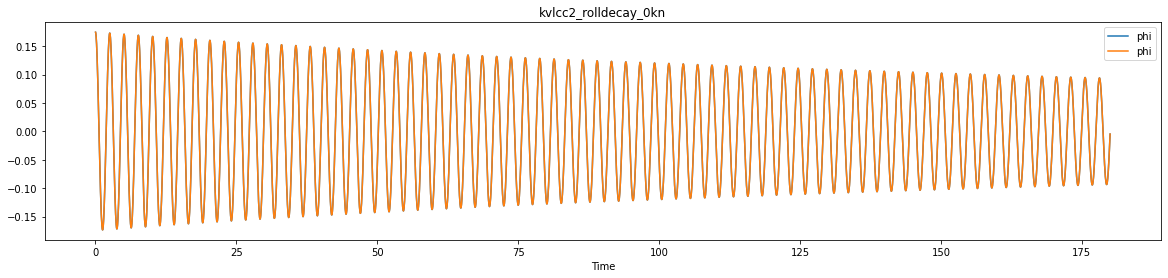

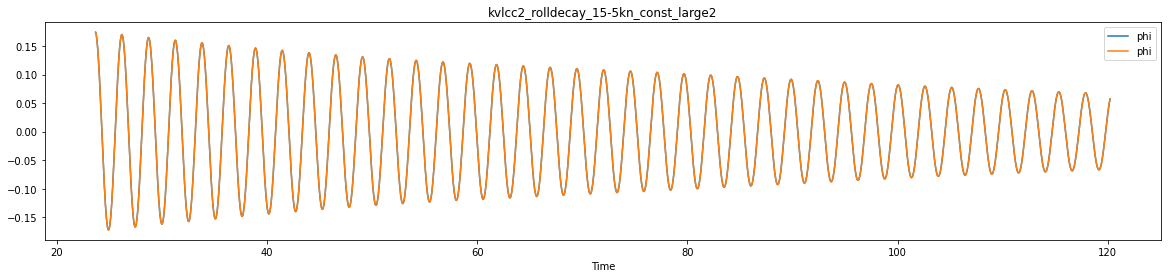

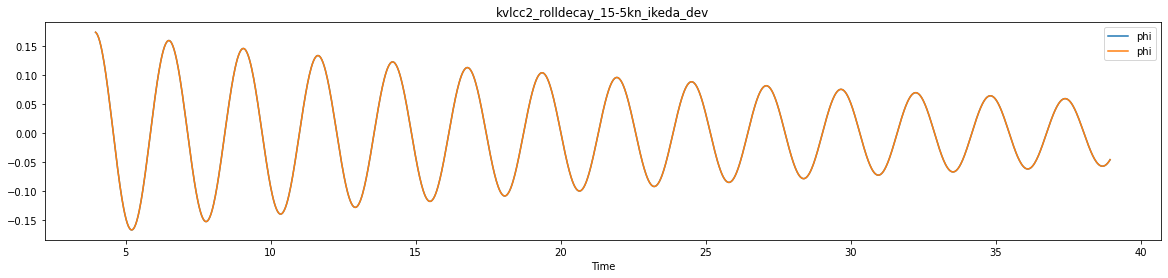

In [10]:
for key, df in time_series.items():
    
    fig,ax = plt.subplots()
    fig.set_size_inches(20,4)
    time_series_raw[key].plot(y='phi', ax=ax)
    df.plot(y='phi', ax=ax)
    ax.set_title(key)

## Fitting

In [11]:
models = OrderedDict()

for key,X in time_series.items():
    
    pre_model= EstimatorQuadraticB(fit_method='derivation')
    pre_model.fit(X)
    
    model_motions = EstimatorQuadraticB(p0=pre_model.parameters)
    
    try:
        model_motions.fit(X=X)
    except scipy.linalg.LinAlgError:
        model_motions.fit(X=X)  # Retry
    
    if pre_model.score() > model_motions.score():
        model_motions = pre_model
        
    models[key] = model_motions

## Genereate results

In [12]:
for key, model in models.items():
    
    parameters = df_parameters.loc[key]
    
    row = df_rolldecays.loc[parameters.id]
    
    scale_factor = row.scale_factor
    meta_data = {
        'Volume' : row.Volume/(scale_factor**3),
        'rho' : row.rho,
        'g' : row.g,
        'GM' : row.gm/scale_factor,
        }

    model.result_for_database(meta_data=meta_data)  # Results are stored in object
    
    if not 'B_3' in model.results:
        model.results['B_3'] = 0
    

## Saving models

In [13]:
for key,model in models.items():
    
    # Saving the model as a pipline:
    pipeline = Pipeline(steps=[('estimator',model)])
    
    joblib.dump(pipeline, '../../models/%s.pkl' % key)
    

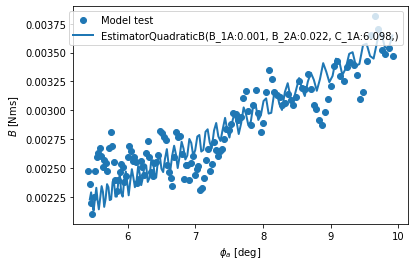

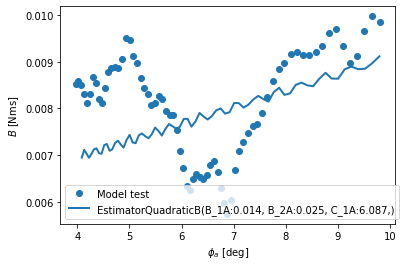

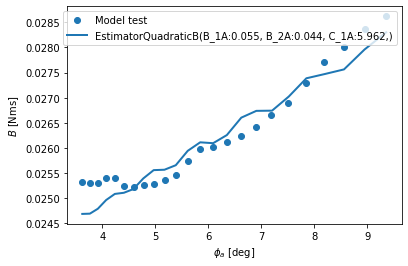

In [14]:
for key,model in models.items():
    
    model.plot_damping()
    